In [1]:
%matplotlib inline
%run -i qiskit_prelude.py
import random
import pickle as pkl
import matplotlib.pyplot as plt
import matplotlib.animation as mpl_animation
QCirc, QInstr, QReg, CReg = QuantumCircuit, Instruction, QuantumRegister, ClassicalRegister
print("all loaded.")

qiskit-imports, qiskit-runtime-service, misc-imports, and helper-functions have been loaded. 
all loaded.


In [69]:
# Set how many bits we are going to use to represent X, Y, and t coordinates
bits_x = 5
bits_y = 5
bits_t = 3

# Set how many boxes there are:
log2_n_boxes = 3
n_boxes = 1 << log2_n_boxes

# Set the maximum number of allowed shifts
n_allowed_shifts = 4

# Convert a positive integer into bits, erroring on overflow
def as_bits(n_orig: int, bits: int):
    n = n_orig
    result = []
    for i in range(bits - 1, -1, -1):
        power = 1 << i
        if n >= power:
            n -= power
            result.append(True)
        else:
            result.append(False)
    if n != 0:
        raise RuntimeError("Overflow (or logic error) in as_bits.")
    return result[::-1]

assert as_bits(23, 5)[::-1] == [True, False, True, True, True]

@dataclass(frozen=True)
class Box:
    x:      int
    y:      int
    t:      int
    log2_w: int # w = width (X)
    log2_h: int # h = height (Y)
    log2_d: int # d = duration (t)
    
    def volume(self) -> int:
        return (2**self.log2_w) + (2**self.log2_h) + (2**self.log2_d)
    
    def get_start_as_bits(self, which: str):
        if   which == "X":
            return as_bits(self.x, bits_x)
        elif which == "Y":
            return as_bits(self.y, bits_y)
        elif which == "t":
            return as_bits(self.t, bits_t)
        else:
            raise RuntimeError("Which dimension (for start) must be X, Y, or t.")
    
    def get_n_offset_bits_by_dim(self, which: str):
        if   which == "X":
            return self.log2_w
        elif which == "Y":
            return self.log2_h
        elif which == "t":
            return self.log2_d
        else:
            raise RuntimeError("Which dimension (for offset) must be X, Y, or t.")

    def contains_point(self, qx: int, qy: int, qt: int):
        x_ok = ((qx - self.x) >= 0) and ((qx - self.x) <= (1 << self.log2_w))
        y_ok = ((qy - self.y) >= 0) and ((qy - self.y) <= (1 << self.log2_h))
        t_ok = ((qt - self.t) >= 0) and ((qt - self.t) <= (1 << self.log2_d))
        return x_ok and y_ok and t_ok

def box_union_contains_point(box_union_of: list[Box], xyt: (int, int, int)):
    x, y, t = xyt
    for box in box_union_of:
        if box.contains_point(x, y, t):
            return True
    return False

In [70]:
CHUNK_NUMBER_FST, CHUNK_NUMBER_SND = 0, 1 # CHANGE THESE TO RENDER DIFFERENT CHUNKS
with open("encoded.pkl", "rb") as f:
    obj = pkl.load(f)
    boxes_fst = [ eval(i) for i in obj[CHUNK_NUMBER_FST] ]
    boxes_snd = [ eval(i) for i in obj[CHUNK_NUMBER_SND] ]
    # look, pickle.load is already unsafe anyway
    # if you're gonna have something be eval-able
    # you might as well commit and have it eval'd twice
boxes_fst[:3], boxes_snd[:3]

([Box(x=2, y=27, t=5, log2_w=4, log2_h=2, log2_d=0),
  Box(x=0, y=31, t=5, log2_w=4, log2_h=0, log2_d=1),
  Box(x=8, y=24, t=5, log2_w=4, log2_h=1, log2_d=0)],
 [Box(x=1, y=3, t=2, log2_w=4, log2_h=3, log2_d=0),
  Box(x=8, y=4, t=1, log2_w=4, log2_h=3, log2_d=0),
  Box(x=0, y=15, t=5, log2_w=4, log2_h=2, log2_d=1)])

In [71]:
def make_instr_show_depth(qc: QCirc) -> QInstr:
    decomposed = qc
    for i in range(10):
        decomposed = decomposed.decompose()
    print(f"[info] [depth-of] {qc.name} -> {decomposed.depth()}")
    return qc.to_instruction()

In [73]:
@dataclass(frozen=True)
class Shift:
    qubit_index_a: int
    qubit_index_b: int
    amount_pr: float
    
    def ry_angle(self):
        return 2 * asin(sqrt(n_boxes * self.amount_pr))

def circ_prepare_box_index(n_shifts: int, shifts: list[Shift], box_volumes: list[int]) -> QCirc:
    # Set up our quantum registers
    unweighted_binary_index = QReg(log2_n_boxes)
    unary_index             = QReg(n_boxes)
    index_distribution      = QReg(n_shifts)
    index_distribution_help = QReg(n_shifts)
    # Create a circuit object
    qc = QuantumCircuit(
        unweighted_binary_index, unary_index,
        index_distribution, index_distribution_help,
        name="prepare_box_index",
    )
    # First, we put the unweighted_binary register into a basic, uniform superposition
    qc.h(unweighted_binary_index)
    # Then, we convert this into an unary index
    qc.append(circ_binary_to_unary(n_boxes, log2_n_boxes), [*unweighted_binary_index, *unary_index])
    # Then, we can weight the unary part (not perfectly, but nothing about this is anywhere close to perfect)
    qc.append(circ_weight_unary(n_shifts, shifts, box_volumes), [*unary_index, *index_distribution, *index_distribution_help])
    return qc

def circ_binary_to_unary(n: int, log2_n: int) -> QInstr:
    # Set up our quantum registers
    binary = QReg(log2_n)
    unary  = QReg(n)
    # Create a circuit object
    qc = QuantumCircuit(binary, unary, name="binary_to_unary")
    # First, we appropriately entangle the first two unary digits
    qc.cx(binary[0], unary[1])
    qc.x(binary[0])
    qc.cx(binary[0], unary[0])
    # Now, we can use a series of CSWAP gates to move the unary digits around
    n_processed = 2
    for i in range(1, log2_n):
        for j in range(n_processed):
            qc.cswap(binary[i], unary[j], unary[j + n_processed])
        n_processed *= 2
    # Return the circuit as an instruction
    return qc.to_instruction()

def circ_weight_unary(n_shifts: int, shifts: list[Shift], box_volumes: list[int]) -> QInstr:
    # Set up our quantum registers
    unary                   = QReg(n_boxes)
    index_distribution      = QReg(n_shifts)
    index_distribution_help = QReg(n_shifts)
    # Create a circuit object
    qc = QuantumCircuit(unary, index_distribution, index_distribution_help, name="weight_unary")
    # Perform the necessary shifts
    for i, shift in enumerate(shifts):
        qc.ry(shift.ry_angle(), index_distribution[i])
        qc.ccx(unary[shift.qubit_index_b], index_distribution[i], index_distribution_help[i])
        qc.cx(index_distribution_help[i], unary[shift.qubit_index_a])
        qc.cx(index_distribution_help[i], unary[shift.qubit_index_b])
    # Return the circuit as an instruction
    return qc.to_instruction()

# First, we need to preprocess the boxes, also giving us n_shifts
def calculate_shifts(boxes: list[Box]) -> tuple[int, list[Shift]]:
    box_volumes = [ box.volume() for box in boxes ]
    desired_box_probabilities = [ volume / sum(box_volumes) for volume in box_volumes ]
    assert len(boxes) == n_boxes
    no_shift_threshold = 0.005
    shifts = []
    required_mean = 1 / n_boxes
    box_indices = list(range(len(boxes)))
    remaining_box_indices = box_indices[:]
    random.shuffle(box_indices)
    for i in box_indices:
        if i not in remaining_box_indices:
            continue
        vol = desired_box_probabilities[i]
        best_vol_diff, best_j = float('inf'), None
        for j in remaining_box_indices:
            if j == i:
                continue
            j_vol = desired_box_probabilities[j]
            vol_mean = (j_vol + vol) / 2
            vol_diff = abs(vol_mean - required_mean)
            if vol_diff < best_vol_diff:
                best_vol_diff = vol_diff
                best_j = j
        best_vol = desired_box_probabilities[best_j]
        if best_vol > vol:
            chosen_hi = best_j
            chosen_lo = i
            shift_amount_p = ((best_vol - required_mean) + (required_mean - vol)) / 2
        else:
            chosen_hi = i
            chosen_lo = best_j
            shift_amount_p = ((vol - required_mean) + (required_mean - best_vol)) / 2
        assert desired_box_probabilities[chosen_hi] >= desired_box_probabilities[chosen_lo]
        assert shift_amount_p >= 0
        if shift_amount_p > no_shift_threshold:      # <- Checks if we even need to shift
            if abs(n_boxes * shift_amount_p) <= 1.0: # <- Checks if we can shift
                shifts.append(Shift(chosen_hi, chosen_lo, shift_amount_p))
        remaining_box_indices.pop(remaining_box_indices.index(i))
        remaining_box_indices.pop(remaining_box_indices.index(best_j))
    print(f"[info]  ideal n_shifts = {len(shifts)}")
    shifts.sort(key=lambda shift: -shift.amount_pr)
    shifts = shifts[:n_allowed_shifts]
    n_shifts = len(shifts)
    print(f"[info] actual n_shifts = {n_shifts}")
    return n_shifts, shifts

sizes_by_dim = {
    "X": bits_x,
    "Y": bits_y,
    "t": bits_t,
}

def circ_index_to_start(blist: list[Box]) -> QCirc:
    # Quantum registers
    unary_index             = QReg(n_boxes     , name="unary_index")
    x_start                 = QReg(bits_x      , name="x_start")
    y_start                 = QReg(bits_y      , name="y_start")
    t_start                 = QReg(bits_t      , name="t_start")
    # Make dictionaries
    starts_by_dim = {
        "X": x_start,
        "Y": y_start,
        "t": t_start,
    }
    # Create circuit object
    qc = QuantumCircuit(unary_index, x_start, y_start, t_start, name="index_to_start")
    # Actual operation
    for i in range(n_boxes):
        for dim in "XYt":
            bits = blist[i].get_start_as_bits(dim)
            for j in range(sizes_by_dim[dim]):
                if bits[j]:
                    qc.cx(unary_index[i], starts_by_dim[dim][j])
    return qc

def circ_index_to_offset(blist: list[Box]) -> QCirc:
    # Quantum registers
    unary_index             = QReg(n_boxes     , name="unary_index")
    x_offset                = QReg(bits_x      , name="x_start")
    y_offset                = QReg(bits_y      , name="y_start")
    t_offset                = QReg(bits_t      , name="t_start")
    # Make dictionaries
    offsets_by_dim = {
        "X": x_offset,
        "Y": y_offset,
        "t": t_offset,
    }
    # Create circuit object
    qc = QuantumCircuit(unary_index, x_offset, y_offset, t_offset, name="index_to_offset")
    # Actual operation
    for i in range(n_boxes):
        for dim in "XYt":
            n_bits = blist[i].get_n_offset_bits_by_dim(dim)
            counter = 0
            for j in range(0, sizes_by_dim[dim]):
                if counter >= n_bits:
                    break
                qc.ch(unary_index[i], offsets_by_dim[dim][j])
                counter += 1
    return qc

def circ_sample_box() -> QCirc:
    # Quantum registers
    x_start                 = QReg(bits_x      , name="x_start")
    x_offset                = QReg(bits_x      , name="x_offset")
    y_start                 = QReg(bits_y      , name="y_start")
    y_offset                = QReg(bits_y      , name="y_offset")
    t_start                 = QReg(bits_t      , name="t_start")
    t_offset                = QReg(bits_t      , name="t_offset")
    addition_help           = QReg(3           , name="addition_help")
    # Dictionaries
    starts_by_dim = {
        "X": x_start,
        "Y": y_start,
        "t": t_start,
    }
    offsets_by_dim = {
        "X": x_offset,
        "Y": y_offset,
        "t": t_offset,
    }
    # Create circuit object
    qc = QuantumCircuit(
        x_start, x_offset,
        y_start, y_offset,
        t_start, t_offset,
        addition_help,
        name="sample_box",
    )
    # Operations (additions in this case)
    for dim_i, dim in enumerate("XYt"):
        qc.append(CDKMRippleCarryAdder(sizes_by_dim[dim], kind="fixed"), [
            *starts_by_dim[dim], *offsets_by_dim[dim], addition_help[dim_i],
        ])
    return qc

# Now, for the overall quantum circuit for a single timeslice
def circ_main_once(blist: list[Box], just_prepare_box_index: bool = False) -> QInstr | int:
    n_shifts, shifts = calculate_shifts(blist)
    # Let's first make all the necessary registers
    # First the quantum ones
    unweighted_binary_index = QReg(log2_n_boxes, name="unweighted_binary_index")
    unary_index             = QReg(n_boxes     , name="unary_index")
    index_distribution      = QReg(n_shifts    , name="index_distribution")
    index_distribution_help = QReg(n_shifts    , name="index_distribution_help")
    x_start                 = QReg(bits_x      , name="x_start")
    x_offset                = QReg(bits_x      , name="x_offset")
    y_start                 = QReg(bits_y      , name="y_start")
    y_offset                = QReg(bits_y      , name="y_offset")
    t_start                 = QReg(bits_t      , name="t_start")
    t_offset                = QReg(bits_t      , name="t_offset")
    addition_help           = QReg(3           , name="addition_help")
    # Create a circuit object
    if just_prepare_box_index:
        qc = QuantumCircuit(
            unweighted_binary_index,
            unary_index,
            index_distribution,
            index_distribution_help,
            name="main_once",
        )
    else:
        qc = QuantumCircuit(
            unweighted_binary_index,
            unary_index,
            index_distribution,
            index_distribution_help,
            x_start, x_offset,
            y_start, y_offset,
            t_start, t_offset,
            addition_help,
            name="main_once",
        )
    # There are four main steps:
    # 1. Prepare a weighted superposition of unary box index states
    qc.append(make_instr_show_depth(circ_prepare_box_index(n_shifts, shifts, [ box.volume() for box in blist ])), [
        *unweighted_binary_index, *unary_index,
        *index_distribution, *index_distribution_help,
    ])
    if just_prepare_box_index:
        return n_shifts, qc.to_instruction()
    # 2. Transform this into a superposition of possible starting points
    qc.append(make_instr_show_depth(circ_index_to_start(blist)), [*unary_index, *x_start, *y_start, *t_start])
    # 3. Transform this into a superposition of offsets
    qc.append(make_instr_show_depth(circ_index_to_offset(blist)), [*unary_index, *x_offset, *y_offset, *t_offset])
    # 4. Add the starting points to the offsets, arriving at a superposition of points
    qc.append(make_instr_show_depth(circ_sample_box()), [
        *x_start, *x_offset,
        *y_start, *y_offset,
        *t_start, *t_offset,
        *addition_help,
    ])
    # Return the circuit as an instruction
    return n_shifts, qc.to_instruction()

def qc_main():
    just_prepare_box_index = False
    n_shifts_fst, main_once_fst = circ_main_once(boxes_fst, just_prepare_box_index=just_prepare_box_index)
    n_shifts_snd, main_once_snd = circ_main_once(boxes_snd, just_prepare_box_index=just_prepare_box_index)
    q_fst = QReg(main_once_fst.num_qubits)
    q_snd = QReg(main_once_snd.num_qubits)
    if just_prepare_box_index:
        fst_unary_out = CReg(n_boxes, name="fst_unary_out")
        snd_unary_out = CReg(n_boxes, name="snd_unary_out")
        qc = QuantumCircuit(
            q_fst, q_snd,
            fst_unary_out, snd_unary_out,
            name="main",
        )
    else:
        fst_x_out                   = CReg(bits_x, name="fst_x_out")
        fst_y_out                   = CReg(bits_y, name="fst_y_out")
        fst_t_out                   = CReg(bits_t, name="fst_t_out")
        snd_x_out                   = CReg(bits_x, name="snd_x_out")
        snd_y_out                   = CReg(bits_y, name="snd_y_out")
        snd_t_out                   = CReg(bits_t, name="snd_t_out")
        qc = QuantumCircuit(
            q_fst, q_snd,
            fst_x_out, fst_y_out, fst_t_out,
            snd_x_out, snd_y_out, snd_t_out,
            name="main",
        )
    qc.append(main_once_fst, q_fst)
    qc.append(main_once_snd, q_snd)
    if just_prepare_box_index:
        qc.measure(q_fst[log2_n_boxes:(log2_n_boxes+n_boxes)], fst_unary_out)
        qc.measure(q_snd[log2_n_boxes:(log2_n_boxes+n_boxes)], snd_unary_out)
    else:
        xyt_offset = log2_n_boxes + n_boxes + n_shifts_fst + n_shifts_fst
        cursor = xyt_offset
        cursor += bits_x
        qc.measure(q_fst[cursor:(cursor := cursor + bits_x)], fst_x_out)
        cursor += bits_y
        qc.measure(q_fst[cursor:(cursor := cursor + bits_y)], fst_y_out)
        cursor += bits_t
        qc.measure(q_fst[cursor:(cursor := cursor + bits_t)], fst_t_out)
        cursor += 3
        assert cursor == main_once_fst.num_qubits
        xyt_offset = log2_n_boxes + n_boxes + n_shifts_snd + n_shifts_snd
        cursor = xyt_offset
        cursor += bits_x
        qc.measure(q_snd[cursor:(cursor := cursor + bits_x)], snd_x_out)
        cursor += bits_y
        qc.measure(q_snd[cursor:(cursor := cursor + bits_y)], snd_y_out)
        cursor += bits_t
        qc.measure(q_snd[cursor:(cursor := cursor + bits_t)], snd_t_out)
        cursor += 3
        assert cursor == main_once_snd.num_qubits
    return qc

In [74]:
main = qc_main()
main.num_qubits

[info]  ideal n_shifts = 1
[info] actual n_shifts = 1
[info] [depth-of] prepare_box_index -> 54
[info] [depth-of] index_to_start -> 16
[info] [depth-of] index_to_offset -> 59
[info] [depth-of] sample_box -> 121
[info]  ideal n_shifts = 2
[info] actual n_shifts = 2
[info] [depth-of] prepare_box_index -> 63
[info] [depth-of] index_to_start -> 11
[info] [depth-of] index_to_offset -> 61
[info] [depth-of] sample_box -> 121


86

In [75]:
decomposed = main
for i in range(10):
    decomposed = decomposed.decompose()
decomposed.depth()

237

In [76]:
print("Getting backend object...")
brisbane = [ i for i in service.backends() if i.name == "ibm_brisbane" ][0]
print("Transpiling...")
transpiled_main = transpile(main, brisbane)
print(f"Transpiled, resulting circuit depth is {transpiled_main.depth()}")

Getting backend object...
Transpiling...
Transpiled, resulting circuit depth is 3125


In [25]:
n_shots = 2048
simulation_result = simulate_quantum_circuit(main, shots=n_shots)

In [28]:
def binstr2dec(s: str):
    # Yes, this is a mind-bogglingy stupid way to do this
    # And an unsafe one at that
    # Hopelessly inefficient too
    # Unfortunately it's 11 P.M. and I don't care
    return eval(f'0b{s}')

def get_coords_from_result(result_keys: list[str]) -> (list[int], list[int], list[int]):
    xs, ys, ts = [], [], []
    for key in result_keys:
        t_snd, y_snd, x_snd, t_fst, y_fst, x_fst = key.split()
        xs.append(binstr2dec(x_fst))
        ys.append(binstr2dec(y_fst))
        ts.append(binstr2dec(t_fst))
        xs.append(binstr2dec(x_snd))
        ys.append(binstr2dec(y_snd))
        ts.append(binstr2dec(t_snd) + (1 << bits_t))
    return xs, ys, ts

result = simulation_result
proportion_noise_threshold = 0.05
coords = get_coords_from_result(result.keys())
good, total = 0, 0
for i in zip(*coords):
    if i[2] >= (1 << bits_t):
        ok = box_union_contains_point(boxes_snd, (
            i[0], i[1], i[2] - (1 << bits_t),
        ))
    else:
        ok = box_union_contains_point(boxes_fst, i)
    good += 1 if ok else 0
    total += 1
print(f'{(good/total)*100:.3f}% OK')

100.000% OK


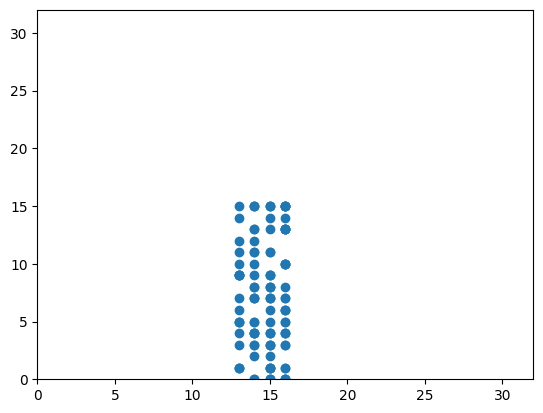

In [32]:
xy_by_time  = [ ([], []) for _ in range(2*(1 << bits_t)) ]
for x, y, t in zip(*coords):
    xy_by_time[t][0].append(x)
    xy_by_time[t][1].append(y)
fig, ax = plt.subplots()
ax.set_xlim(0, 1 << bits_x)
ax.set_ylim(0, 1 << bits_y)
scatter = ax.scatter(*xy_by_time[0][::-1])
def scatter_ani_draw(frame):
    arr = np.vstack([
        np.array(xy_by_time[frame][1]),
        np.array(xy_by_time[frame][0])
    ]).T
    if arr.size > 0:
        scatter.set_offsets(arr)
    else:
        scatter.set_offsets(np.array([0, 0]))
    return (scatter,)
scatter_ani = mpl_animation.FuncAnimation(fig, scatter_ani_draw, frames=2*(1 << bits_t), interval=(1000//7), blit=True)
scatter_ani.save("output.gif", writer="pillow")